# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
df = pd.read_csv('/content/Data Penjualan Toko Buku.csv')
df.head()

,id_transaksi,jenis_item,jumlah,tanggal pembelian,nama_customer,total
0,133889.0,Alat Tulis,1,1/1/2010,Stacy Campos,120000.0
1,133889.0,Buku Sejarah,1,1/1/2010,Stacy Campos,150000.0
2,133889.0,Buku Anak-Anak,2,1/1/2010,Stacy Campos,400000.0
3,133889.0,Majalah Fashion,1,1/1/2010,Stacy Campos,130000.0
4,133889.0,Majalah Berita,2,1/1/2010,Stacy Campos,600000.0


# Preprocessing

In [3]:
df.isna().sum()

,0
id_transaksi,771
jenis_item,771
jumlah,0
tanggal pembelian,3
nama_customer,771
total,2


In [6]:
df = df.dropna()

In [7]:
df.isna().sum()

,0
id_transaksi,0
jenis_item,0
jumlah,0
tanggal pembelian,0
nama_customer,0
total,0


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df['id_transaksi'] = df['id_transaksi'].astype(int)
df['total'] = df['total'].astype(int)
df = df[df['jumlah'] > 0].copy()

In [10]:
df['harga_satuan'] = (df['total'] / df['jumlah']).round(0).astype(int)

/tmp/ipython-input-2610795549.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


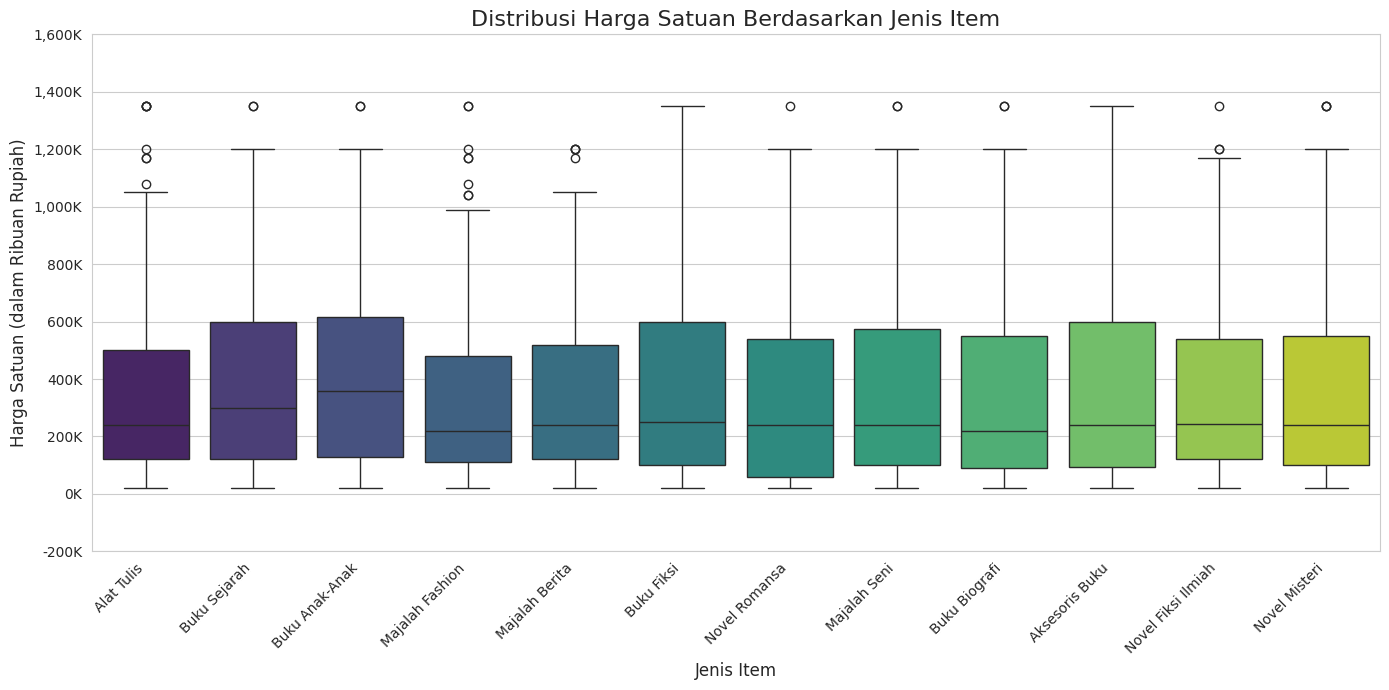

In [14]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df,
    x='jenis_item',
    y='harga_satuan',
    palette='viridis'
)
plt.title('Distribusi Harga Satuan Berdasarkan Jenis Item', fontsize=16)
plt.xlabel('Jenis Item', fontsize=12)
plt.ylabel('Harga Satuan (dalam Ribuan Rupiah)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(plt.yticks()[0], [f'{y/1000:,.0f}K' for y in plt.yticks()[0]])
plt.tight_layout()
plt.show()

# Analisis RFM

In [17]:
df['tanggal pembelian'] = pd.to_datetime(df['tanggal pembelian'])
snapshot_date = df['tanggal pembelian'].max() + pd.Timedelta(days=1)
print(f"Tanggal Snapshot (Today's Date): {snapshot_date.date()}")

Tanggal Snapshot (Today's Date): 2024-05-01


In [19]:
rfm_df = df.groupby('nama_customer').agg(

    Recency=('tanggal pembelian', lambda x: (snapshot_date - x.max()).days),
    Frequency=('id_transaksi', 'nunique'),
    Monetary=('total', 'sum')
).reset_index()

In [24]:
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1])

rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], 4, labels=False, duplicates='drop') + 1
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 4, labels=False, duplicates='drop') + 1

In [26]:
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

rfm_df['Monetary (Juta)'] = (rfm_df['Monetary'] / 1000000).round(2)

print("RFM Analysis Head\n")
print(rfm_df.sort_values(by='RFM_Score', ascending=False).head().to_markdown(index=False))

RFM Analysis Head

| nama_customer        |   Recency |   Frequency |   Monetary |   R_Score |   F_Score |   M_Score |   RFM_Score |   Monetary (Juta) |
|:---------------------|----------:|------------:|-----------:|----------:|----------:|----------:|------------:|------------------:|
| Christopher Gonzalez |         1 |           1 |   21470000 |         4 |         1 |         4 |         414 |             21.47 |
| Joshua Moore         |       702 |           1 |   20770000 |         4 |         1 |         4 |         414 |             20.77 |
| Diana Long           |         1 |           1 |   28280000 |         4 |         1 |         4 |         414 |             28.28 |
| Patrick Morris       |       702 |           1 |   19920000 |         4 |         1 |         4 |         414 |             19.92 |
| Belinda Powell       |         1 |           1 |   31965000 |         4 |         1 |         4 |         414 |             31.96 |


In [33]:
df['tahun'] = df['tanggal pembelian'].dt.year

def rfm_segment(row):
    if row['R_Score'] == 4 and row['F_Score'] == 4 and row['M_Score'] == 4:
        return '1. Champions'
    elif row['R_Score'] == 4 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
        return '2. Loyal Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return '3. Potential Loyalists'
    elif row['R_Score'] == 4 and row['F_Score'] == 1 and row['M_Score'] == 1:
        return '4. New Customers'
    elif row['R_Score'] == 3 and row['F_Score'] == 1 and row['M_Score'] == 1:
        return '5. Promising'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
        return '6. At Risk'
    elif row['R_Score'] <= 1 and row['F_Score'] <= 1 and row['M_Score'] <= 1:
        return '7. Lost Customers'
    else:
        return '8. Others'

rfm_df['Segment'] = rfm_df.apply(rfm_segment, axis=1)

# Visualisasi Data

In [35]:
# KPI 1: Tren Penjualan Tahunan
sales_trend = df.groupby('tahun')['total'].sum().reset_index()

# KPI 2: Top Item Berdasarkan Pendapatan
top_revenue = df.groupby('jenis_item')['total'].sum().nlargest(10).reset_index()

# KPI 3: Distribusi Segmen RFM
segment_counts = rfm_df['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

/tmp/ipython-input-985781137.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_revenue, x='total', y='jenis_item', palette='Reds_d', ax=axes[0, 1])
/tmp/ipython-input-985781137.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='Count', y='Segment', palette='Spectral', ax=axes[1, 0])


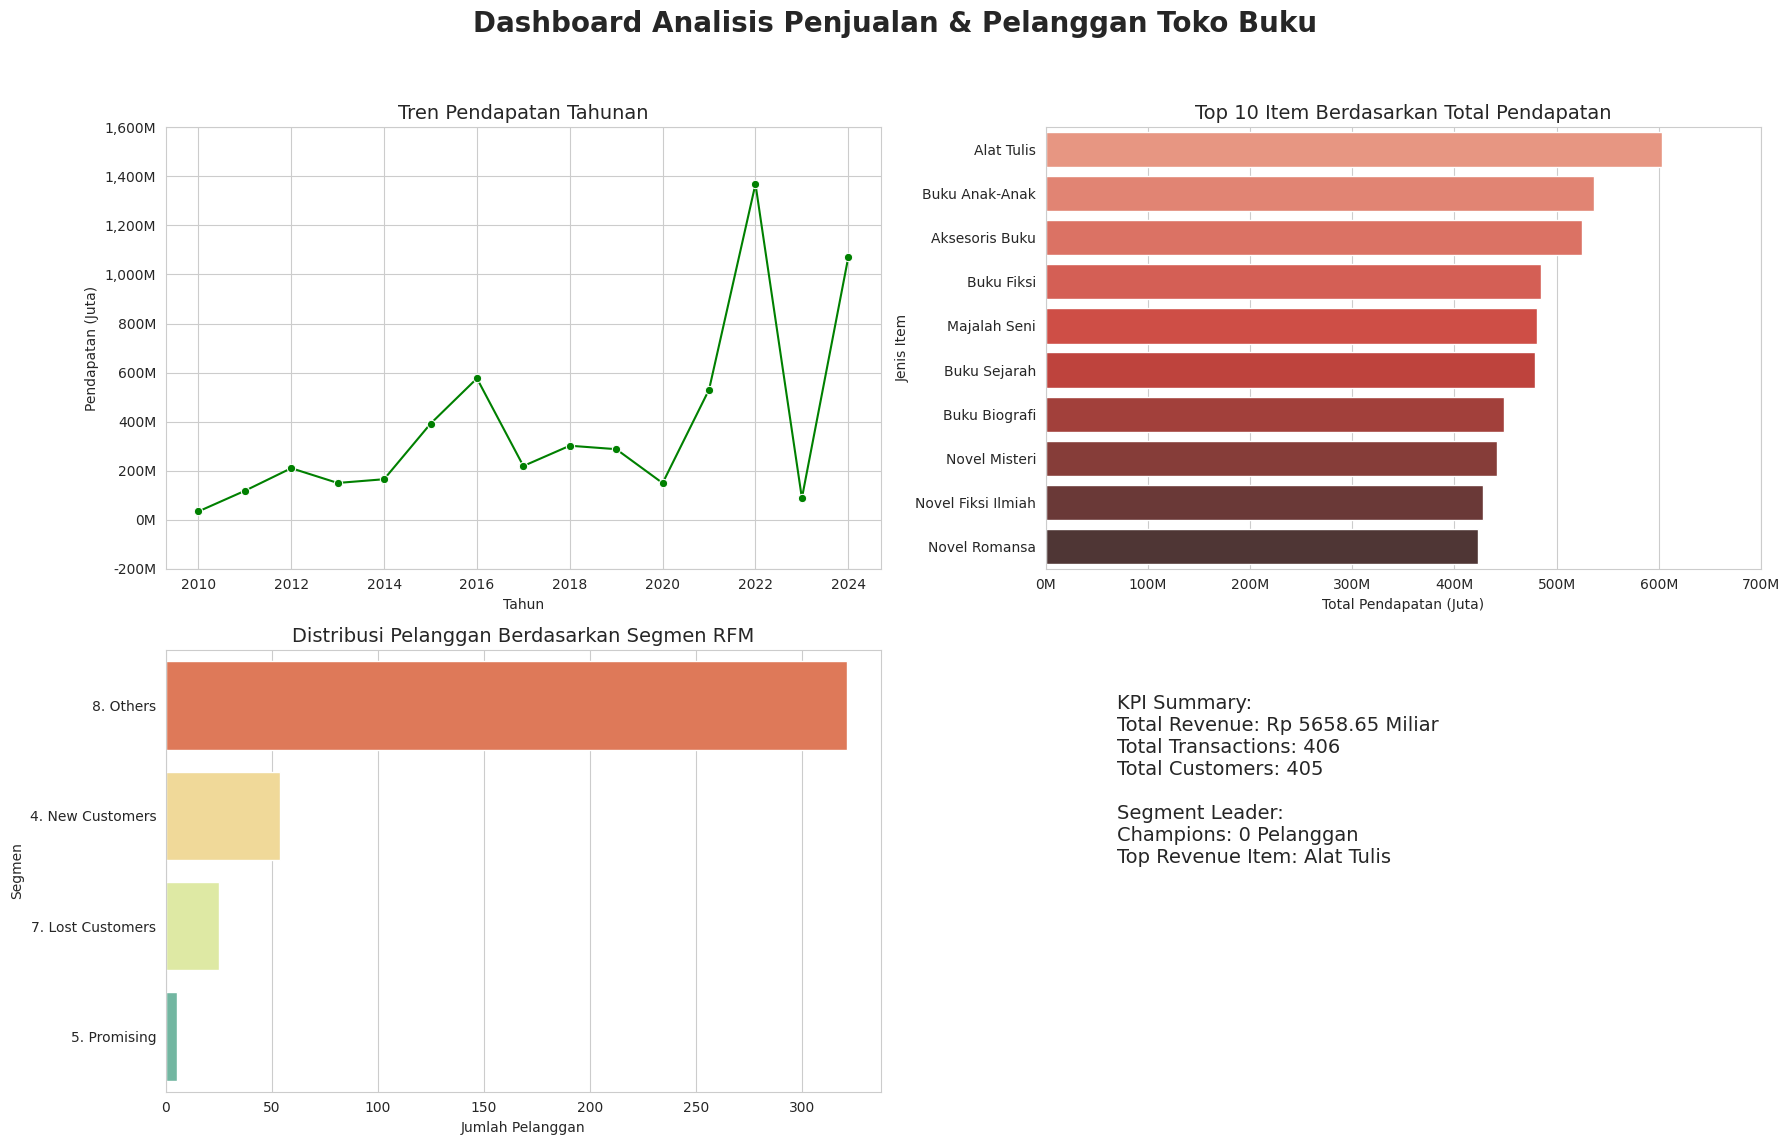

In [36]:
# Dashboard Assembly
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Dashboard Analisis Penjualan & Pelanggan Toko Buku', fontsize=20, fontweight='bold')

# Plot 1: Tren Penjualan Per Tahun
sns.lineplot(data=sales_trend, x='tahun', y='total', marker='o', color='green', ax=axes[0, 0])
axes[0, 0].set_title('Tren Pendapatan Tahunan', fontsize=14)
axes[0, 0].set_xlabel('Tahun')
axes[0, 0].set_ylabel('Pendapatan (Juta)')
axes[0, 0].ticklabel_format(style='plain', axis='y')
axes[0, 0].set_yticks(axes[0, 0].get_yticks(), [f'{y/1000000:,.0f}M' for y in axes[0, 0].get_yticks()])

# Plot 2: Top 10 Item Berdasarkan Pendapatan
sns.barplot(data=top_revenue, x='total', y='jenis_item', palette='Reds_d', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Item Berdasarkan Total Pendapatan', fontsize=14)
axes[0, 1].set_xlabel('Total Pendapatan (Juta)')
axes[0, 1].set_ylabel('Jenis Item')
axes[0, 1].ticklabel_format(style='plain', axis='x')
axes[0, 1].set_xticks(axes[0, 1].get_xticks(), [f'{x/1000000:,.0f}M' for x in axes[0, 1].get_xticks()])

# Plot 3: Distribusi Segmentasi RFM
sns.barplot(data=segment_counts, x='Count', y='Segment', palette='Spectral', ax=axes[1, 0])
axes[1, 0].set_title('Distribusi Pelanggan Berdasarkan Segmen RFM', fontsize=14)
axes[1, 0].set_xlabel('Jumlah Pelanggan')
axes[1, 0].set_ylabel('Segmen')

axes[1, 1].axis('off')

champions_count_row = segment_counts[segment_counts['Segment'] == '1. Champions']
champions_count = champions_count_row['Count'].iloc[0] if not champions_count_row.empty else 0

kpi_text = (
    f"KPI Summary:\n"
    f"Total Revenue: Rp {df['total'].sum()/1000000:.2f} Miliar\n"
    f"Total Transactions: {df['id_transaksi'].nunique():,}\n"
    f"Total Customers: {rfm_df.shape[0]:,}\n\n"
    f"Segment Leader:\n"
    f"Champions: {champions_count} Pelanggan\n"
    f"Top Revenue Item: {top_revenue['jenis_item'].iloc[0]}"
)
axes[1, 1].text(0.1, 0.9, kpi_text, transform=axes[1, 1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle="round,pad=1", fc="white", alpha=0.7))


plt.tight_layout(rect=[0, 0.03, 1, 0.95])